# Tutorial for LEAP-REU data processing and visualization

**Authors: Yu Huang, Sungduk Yu**

GitHub repository links: [tutorials for REU dataset](https://github.com/sungdukyu/LEAP_REU_Dataset_Notebook); [LEAP-REU23 Bootcamp](https://github.com/leap-stc/LEAP-bootcamps).

It is an introductory tutorial for a demo dataset from the climate model [E3SM-MMF](https://www.exascaleproject.org/research-project/e3sm-mmf/). See [E3SM-MMF_baseline](https://github.com/sungdukyu/E3SM-MMF_baseline/tree/main) and [E3SM](https://e3sm.org/wp-content/uploads/2021/11/E3SM_Brochure-2021.pdf) for more information.

This notebook includes preprocessing of the unstructured data, which cannot be managed by xarray directly, and visualization of climate variables. 

The goal is to practice the skills covered during Week1 of the bootcamp to carry out climate analysis, and to get more familiar with the climate concepts using the REU dataset.


## Git Authentification

Use terminal or the left side bar to push your files if you want to use Git to keep track of your file.

Run the below code to give LEAP-Pangeo access to your Github account.

In [1]:
import gh_scoped_creds
%ghscopedcreds

<IPython.core.display.Javascript object>

The code 0B6D-EF23 has been copied to your clipboard.
You have 15 minutes to go to https://github.com/login/device and paste it there.

Waiting......


Visit https://github.com/apps/leap-hub-push-access to manage list of repositories you can push to from this location
Tip: Use https:// URLs to clone and push to repos, not ssh URLs!


## Data preprocessing
### Install and load python packages

We use [mamba](https://mamba.readthedocs.io/en/latest/installation.html) (instead of conda) to install packages on Hub. Please click the "+" button on the leftup corner to launch a terminal, copy the below commands after "!" and run them on the terminal if you cannot directly import them

In [2]:
# ! mamba install -y pynco pynio pyngl

In [6]:
import gcsfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cftime
from nco import Nco
from tqdm import tqdm
import Ngl
import xesmf as xe

### Load dataset from Google Cloud

#### Open Google Cloud Storage File System


In [7]:
fs = gcsfs.GCSFileSystem()

#### List files in the bucket where the E3SM-MMF dataset is stored


In [8]:
fs.ls("gs://leap-persistent-ro/sungdukyu")

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.output.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr',
 'leap-persistent-ro/sungdukyu/testing']

#### Open the file you want using xarray


In [9]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds = xr.open_dataset(mapper, engine='zarr')


#### Check which variables are included & their dimensions/shapes 

Use [E3SM-MMF Dataset Variable List](https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0) to check the physical meaning of each variable.

Check the original data coordinates first. Instead of using time, latitude, longitude as the coordinates, the raw data uses **sample**(time step) and **ncol**(column index).


In [10]:
ds

<xarray.Dataset>
Dimensions:         (sample: 210240, ncol: 384, lev: 60)
Dimensions without coordinates: sample, ncol, lev
Data variables: (12/16)
    cam_out_FLWDS   (sample, ncol) float64 ...
    cam_out_NETSW   (sample, ncol) float64 ...
    cam_out_PRECC   (sample, ncol) float64 ...
    cam_out_PRECSC  (sample, ncol) float64 ...
    cam_out_SOLL    (sample, ncol) float64 ...
    cam_out_SOLLD   (sample, ncol) float64 ...
    ...              ...
    state_q0003     (sample, lev, ncol) float64 ...
    state_t         (sample, lev, ncol) float64 ...
    state_u         (sample, lev, ncol) float64 ...
    state_v         (sample, lev, ncol) float64 ...
    tod             (sample) int32 ...
    ymd             (sample) int32 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Reorganize the temporal dimension/coordinate

#### Add the *time* dimension  
Originally the time information is coded in the variables **ymd** and **tod**. The **sample** index represents the time step count. 

**ymd** includes date information: the first digit indicates the index of year, the next two digits indicate the month and the last three digits indicates the calendar day in the year.

**tod** represents time in the day counted in seconds.

In [11]:
ds.ymd.values[0], ds.tod.values[0]

(10201, 0)

In [12]:
# loop over all sample points
year=ds['ymd']//10000
month=ds['ymd']%10000//100
day=ds['ymd']%10000%100
hour=ds['tod']//3600
minute=ds['tod']%3600//60

k=0
t = []
for k in range(len(ds['ymd'])):
    t.append(cftime.DatetimeNoLeap(year[k],month[k],day[k],hour[k],minute[k]))

# add the time array to the 'sample' dimension; then, rename
ds['sample'] = t
ds = ds.rename({'sample':'time'})

# now 'time' dimension replaced 'sample' dimension.
ds = ds.drop(['tod','ymd'])

# Check the current **time** dimension, read the timestep
ds.time.values[0:5]

array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 20, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 40, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 20, 0, 0, has_year_zero=True)],
      dtype=object)

#### Reduce the data size/coarse the time resolution 

The **time** dimension is large. For avoid memory issues, currently we'll keep only one sample each day. 

You can take the daily/monthly mean/max/min data or the data at a specific time each day. 

There are many ways to do that. You can uncomment the codes to try.

In [13]:
# keep a copy of the original data at 20-min time step and gridded by column index
ds_origin = ds.copy()

# 1. tried to resample the whole dataset but then the memory blows up
# ds = ds.resample(time='1D').mean('time')
# ds

# 2. select data at noon per day for the whole dataset 
# itime = np.arange(36,len(ds.time),24*3)
# ds = ds.isel(time = itime)
# ds

I can continue taking the monthly mean using *resample* function, which will further reduce the data size. It requires more memory so I only process two 2D variables here *total precipitation* and *net surface shortwave radiation*. For the sake of convenience, I will loosely refer to these two variables as 'precipitation' and 'radiation' in the later analysis.

In [14]:
# resample the data to be monthly instead of daily
# first do the transformation so we have: total precipitation = snow + rainfall

ds['cam_out_PRECT'] = ds['cam_out_PRECC'] + ds['cam_out_PRECSC']
ds = ds[['cam_out_PRECT', 'cam_out_NETSW']].resample(time='1M').mean(dim='time')
ds

<xarray.Dataset>
Dimensions:        (time: 96, ncol: 384)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
Dimensions without coordinates: ncol
Data variables:
    cam_out_PRECT  (time, ncol) float64 1.826e-09 1.298e-08 ... 3.901e-08
    cam_out_NETSW  (time, ncol) float64 291.1 247.9 252.8 ... 34.52 57.44 76.93
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Remap and interpolate the data so that they have structured lat, lon coordinates

#### Open a file that stores grid information, and check the original lat, lon information

In [15]:
# grid info
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')
ds_grid

<xarray.Dataset>
Dimensions:  (ncol: 384, ilev: 61, lev: 60)
Dimensions without coordinates: ncol, ilev, lev
Data variables:
    P0       float64 ...
    area     (ncol) float64 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
    lat      (ncol) float64 ...
    lon      (ncol) float64 ...
Attributes: (12/19)
    Conventions:       CF-1.7
    case:              E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2
    contact:           e3sm-data-support@listserv.llnl.gov
    fv_nphys:          2
    git_version:       4108bd8c11
    history:           created on 01/13/23 15:30:04
    ...                ...
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    time_period_freq:  month_1
    title:             EAM History file information
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    username:          sungduk

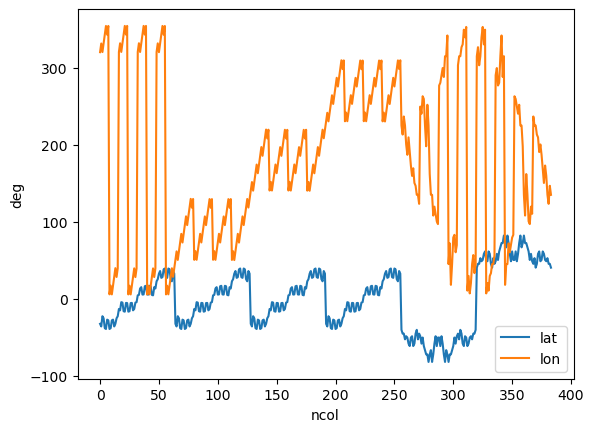

In [16]:
fig, ax = plt.subplots()
ds_grid['lat'].plot(label='lat', ax=ax)
ds_grid['lon'].plot(label='lon', ax=ax)
ax.set_ylabel('deg')
ax.legend()

In [17]:
print('column number is ',len(np.unique(ds_grid.ncol.values)))
print('if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is', len(np.unique(ds_grid.lat.values))*len(np.unique(ds_grid.lon.values)))
np.unique(ds_grid.lon.values.round(2))

column number is  384
if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is 17313


array([  5.63,   5.65,   5.68,   5.73,   6.97,  10.54,  16.89,  16.91,
        16.96,  17.02,  18.06,  20.4 ,  28.15,  28.2 ,  28.31,  28.47,
        29.62,  33.28,  39.4 ,  39.46,  39.56,  39.73,  45.  ,  50.27,
        50.44,  50.54,  50.6 ,  56.72,  60.38,  61.53,  61.69,  61.8 ,
        61.85,  69.6 ,  71.94,  72.98,  73.04,  73.09,  73.11,  79.46,
        83.03,  84.27,  84.32,  84.35,  84.37,  95.63,  95.65,  95.68,
        95.73,  96.97, 100.54, 106.89, 106.91, 106.96, 107.02, 108.06,
       110.4 , 118.15, 118.2 , 118.31, 118.47, 119.62, 123.28, 129.4 ,
       129.46, 129.56, 129.73, 135.  , 140.27, 140.44, 140.54, 140.6 ,
       146.72, 150.38, 151.53, 151.69, 151.8 , 151.85, 159.6 , 161.94,
       162.98, 163.04, 163.09, 163.11, 169.46, 173.03, 174.27, 174.32,
       174.35, 174.37, 185.63, 185.65, 185.68, 185.73, 186.97, 190.54,
       196.89, 196.91, 196.96, 197.02, 198.06, 200.4 , 208.15, 208.2 ,
       208.31, 208.47, 209.62, 213.28, 219.4 , 219.46, 219.56, 219.73,
      

#### Change the geo-coordinate from column index to multi-index (lat, lon) and see what the data looks like

In [18]:
# original lat and lon info
lat = ds_grid.lat.values.round(2) 
lon = ds_grid.lon.values.round(2) 

# merge the original grid info with the dataset containing atmos variables
ds_multiindex = ds.copy()
ds_multiindex['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
ds_multiindex['lon'] = (('ncol'),lon.T)

# set multi-index for the original dataset using lat and lon
ds_multiindex = ds_multiindex.set_index(index_id=["lat", "lon"])
index_id = ds_multiindex.index_id
ds_multiindex = ds_multiindex.drop('index_id')
ds_multiindex = ds_multiindex.rename({'ncol':'index_id'})
ds_multiindex = ds_multiindex.assign_coords(index_id = index_id)
ds_multiindex

<xarray.Dataset>
Dimensions:        (time: 96, index_id: 384)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * lat            (index_id) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
  * lon            (index_id) float64 320.3 331.5 320.4 ... 123.3 146.7 135.0
  * index_id       (index_id) object MultiIndex
Data variables:
    cam_out_PRECT  (time, index_id) float64 1.826e-09 1.298e-08 ... 3.901e-08
    cam_out_NETSW  (time, index_id) float64 291.1 247.9 252.8 ... 57.44 76.93
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [19]:
# create a dataset with stacked (lat, lon) grids in the original dataset, all values are NaNs
time = ds.time.values

data_np = np.empty(shape=(len(time), len(np.unique(lat)),len(np.unique(lon))))
data_np[:,:] = np.nan

ds_latlon = xr.Dataset(
     data_vars={
         # v: (("time","index_id"), np.zeros([len(time), len(np.unique(lat))*len(np.unique(lon))]))
         v: (("time","lat","lon"), data_np)
         for v in ['cam_out_NETSW','cam_out_PRECT']
     },
     coords={
         "time": ds.time,
         # "index_id": pd.MultiIndex.from_product(
         #    [np.unique(lat), np.unique(lon)], names=["lat", "lon"],),
         "lat": np.unique(lat),
         "lon": np.unique(lon),
         # "lev": ds.lev,
    },
)

# use multi-index so that we can assign the column data to the (lat,lon) data
ds_latlon = ds_latlon.stack(index_id=['lat','lon'])
ds_latlon 

# print(len(ds_multiindex.index_id.values))
# ds_latlon.sel(index_id=(-32.59, 320.27))

<xarray.Dataset>
Dimensions:        (time: 96, index_id: 9360)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * index_id       (index_id) object MultiIndex
  * lat            (index_id) float64 -82.06 -82.06 -82.06 ... 82.06 82.06 82.06
  * lon            (index_id) float64 5.63 5.65 5.68 5.73 ... 354.3 354.4 354.4
Data variables:
    cam_out_NETSW  (time, index_id) float64 nan nan nan nan ... nan nan nan nan
    cam_out_PRECT  (time, index_id) float64 nan nan nan nan ... nan nan nan nan

100%|██████████| 384/384 [00:00<00:00, 574.10it/s]


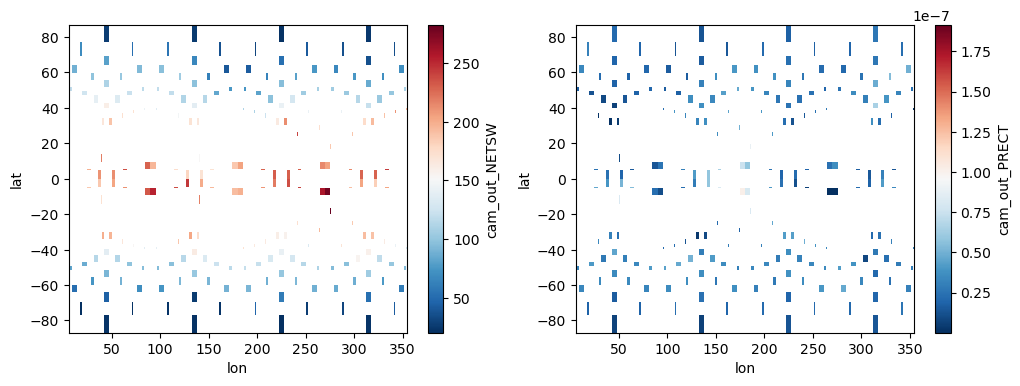

In [20]:
# use tqdm to visualize the progress of the below loop
# this cell takes about 20min to run, please patiently wait when it is run
ds_precc = ds_latlon.cam_out_PRECT.copy()
ds_netsw = ds_latlon.cam_out_NETSW.copy()

for i in tqdm(ds_multiindex.index_id.values):
    # ds_latlon.loc[{"index_id": i}] = ds_multiindex[[' cam_out_NETSW','cam_out_PRECC']].sel(index_id = i) 
    #### wrong, will lead to all vars have the same values
    ds_precc.loc[{"index_id": i}] = ds_multiindex['cam_out_PRECT'].sel(index_id = i)
    ds_netsw.loc[{"index_id": i}] = ds_multiindex['cam_out_NETSW'].sel(index_id = i)

ds_latlon['cam_out_PRECT'] = ds_precc.copy()
ds_latlon['cam_out_NETSW'] = ds_netsw.copy()

ds_unstack = ds_latlon.unstack('index_id')
ds_unstack

## if we directly visualize the 2D maps, then there are many missing values 
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ds_unstack. cam_out_NETSW.mean('time').plot(cmap='RdBu_r',ax=ax[0])
ds_unstack.cam_out_PRECT.mean('time').plot(cmap='RdBu_r',ax=ax[1])

<span style="color:blue"> **Look, the raw dataset is visualized weirdly directly using xarray because it is on an unstructured grid and xarray cannot handle these coordinate points properly. See [page 9](https://www.osti.gov/servlets/purl/1807356) to know more about the raw grid setup.**</span>

#### What does the raw grid look like?

Use [pynco](https://pynco.readthedocs.io/en/stable/) to remap data on the unstructured grid to a structured grid. Do not bother yourself to try to understand this kind of grid right now.

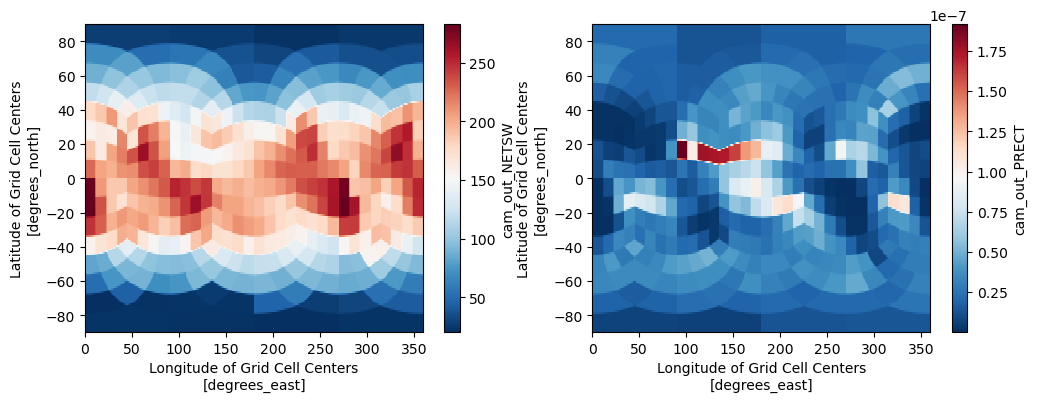

In [21]:
infile = '../E3SM-MMF_ne4_train_output_monthly_raw.nc'
outfile = '../E3SM-MMF_ne4_train_output_monthly_remap.nc'
#Mapfile to convert unstructured data to gridded data
mapfile = '../map_ne4pg2_to_180x360_aave.20220722.nc'

ds.to_netcdf('../E3SM-MMF_ne4_train_output_monthly_raw.nc')

nco = Nco()
nco.ncks(input=infile, output=outfile, map=mapfile)

ds_remap = xr.open_dataset(outfile)

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ds_remap['cam_out_NETSW'].mean('time').plot(cmap='RdBu_r',ax=ax[0])
ds_remap['cam_out_PRECT'].mean('time').plot(cmap='RdBu_r',ax=ax[1])

In [22]:
ds_remap

<xarray.Dataset>
Dimensions:        (lat: 180, lon: 360, nbnd: 2, time: 96)
Coordinates:
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon            (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds       (lat, nbnd) float64 ...
    lon_bnds       (lon, nbnd) float64 ...
    gw             (lat) float64 ...
    area           (lat, lon) float64 ...
    cam_out_NETSW  (time, lat, lon) float64 30.25 30.25 30.25 ... 0.0 0.0 0.0
    cam_out_PRECT  (time, lat, lon) float64 9.563e-09 9.563e-09 ... 2.29e-08
Attributes:
    calendar:                  NO_LEAP
    fv_nphys:                  2
    ne:                        4
    history:                   Thu Jun  8 15:29:35 2023: /srv/conda/envs/note...
    NCO:                       netCDF Operators version 5.1.5 (Homepage = htt...
    nco_openmp_thread_number:  16
    title:                     Regridded version of E3SM-MMF_ne4_train_output...
    map_file:                  ../map_ne4pg2_to_180x360_aave.20220722.nc
    input_file:                ../E3SM-MMF_ne4_train_output_monthly_raw.nc

#### Interpolate the unstructured data at 2-deg resolution

For simplicity and memory consideration, we use a tool [PyNGL](https://www.pyngl.ucar.edu/Functions/Ngl.natgrid.shtml) to interpolate the **RAW** data to make it structured on the grid we want, so that we can make some climate analysis using the skills you learned earlier this week. 


In [23]:
# original lat and lon info
ncol = ds.ncol.values

# new lat and lon grids that we finally want
nlat = np.arange(-90, 90.5, 2)
nlon = np.arange(0, 360, 2)

# create a nan-value xr dataset to contain new remapped & interpolated data 
data_var = np.empty([len(time), len(nlat), len(nlon)])
data_var[:,:,:] = np.nan

ds_new = xr.Dataset(
     data_vars={
         v: (("time","lat","lon"), data_var)
         for v in ['cam_out_NETSW','cam_out_PRECT']
     },
     coords={
         "time": ds.time,
         "lat": nlat,
         "lon": nlon,
        # "lev": ds.lev,
    },
)

ds_new

<xarray.Dataset>
Dimensions:        (time: 96, lat: 91, lon: 180)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * lat            (lat) float64 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon            (lon) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
Data variables:
    cam_out_NETSW  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    cam_out_PRECT  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [24]:
data_prect = data_var.copy()
data_netsw = data_var.copy()

# interpolate the data using pyngl
# optional: use multiprocessing to save the running time

for it, tt in enumerate(ds.time):
    data = ds.sel(time=tt).cam_out_NETSW.values
    iarr = Ngl.natgrid(lat, lon, data, nlat, nlon) #.squeeze()
    data_netsw[it,:] = iarr
    
    data = ds.sel(time=tt).cam_out_PRECT.values
    iarr = Ngl.natgrid(lat, lon, data, nlat, nlon) #.squeeze()
    data_prect[it,:] = iarr

ds_new['cam_out_NETSW'].values = data_netsw
ds_new['cam_out_PRECT'].values = data_prect

Text(0.5, 1.0, 'Total Precip (m/s)')

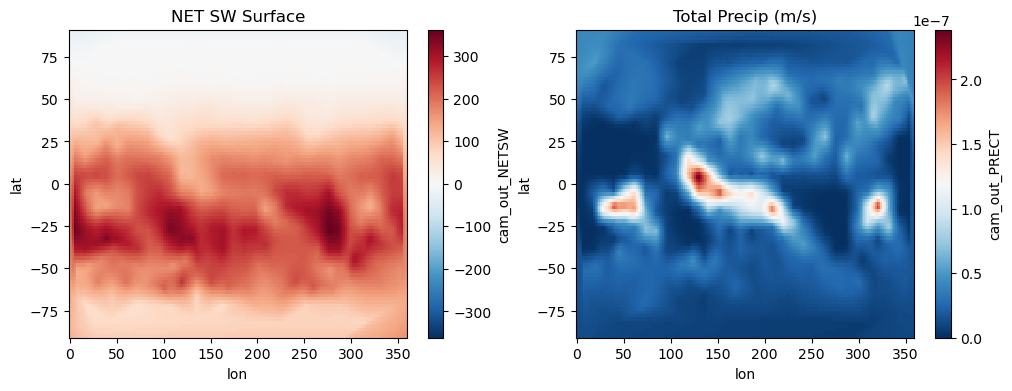

In [25]:
# plot the maps of these two variables at a specific time step

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ds_new['cam_out_NETSW'].isel(time=10).plot(cmap='RdBu_r',ax=ax[0])
ds_new['cam_out_PRECT'].isel(time=10).plot(cmap='RdBu_r',ax=ax[1])
ax[0].set_title('NET SW Surface')
ax[1].set_title('Total Precip (m/s)')

The maps looks smoother and closer to the realistic condition.


## Now, analysis and visualization can be done using xarray

<span style="color:blue"> Work in a group of 2, each group should finish two sections of analysis. Please use the plotting skills you learned to make the figures look well-annotated, nice and clear. Use Google or ChatGPT if you have questions regarding the climate concepts. </span>
    
### [Analysis 1] Time series and trend

We can use the original dataset to calculate the *global mean* (spatial mean) time series. The unit for precipitation is m/s. 

Note it should be the weighted average mean based on the area of each atmos grid/column. Here we provide you the grid area data so you do not need to calculate it.

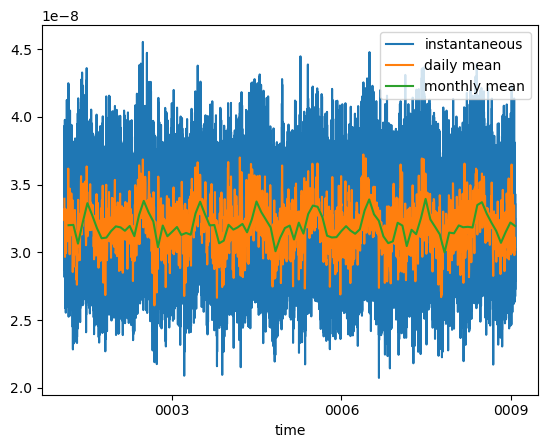

In [26]:
# here we use the data whose dimension size was not reduced
ds_origin = xr.merge([ds_grid, ds_origin])

# total precipitation = rainfall + snowfall
PRECT = ds_origin['cam_out_PRECC'] + ds_origin['cam_out_PRECSC']

# area-weighted global mean PRECT
# required concept: avg weights, broadcast, resampling
PRECT_mean = (PRECT * (ds_origin['area']/ds_origin['area'].sum())).sum('ncol')
PRECT_mean_daily = PRECT_mean.resample(time='1D').mean('time')
PRECT_mean_monthly = PRECT_mean.resample(time='1M').mean('time')

# visualization
fig, ax = plt.subplots()
PRECT_mean.plot(label='instantaneous', ax=ax)
PRECT_mean_daily.plot(label='daily mean', ax=ax)
PRECT_mean_monthly.plot(label='monthly mean', ax=ax)
ax.legend()

Or, we can use use the processed dataset on structured lat/lon coordinates. In this case, we need to calculate the area of each 2x2 degree grid. You'll only be able to show the time series of monthly mean data or annual data, because we've resampled it at the monthly frequency.

Please show the time series of global weighted mean cam_out_NETSW using the processed dataset *ds_new*. Refer your Assignment #1.

Text(0.5, 0, 'Year')

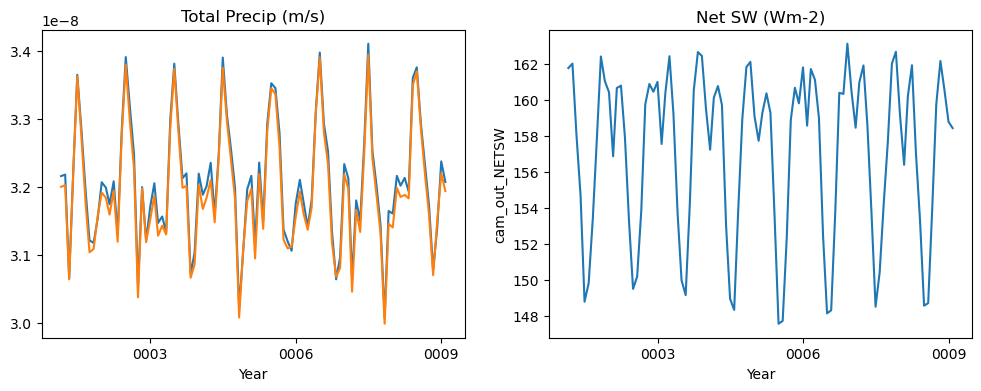

In [27]:
##### to be implemented...
weights  = np.cos(np.deg2rad(ds_new.lat))/np.cos(np.deg2rad(ds_new.lat)).mean()

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
# Total Precip
ds_new.cam_out_PRECT.weighted(weights).mean(dim=('lat','lon')).plot(ax=ax[0], label='interpolated data')
PRECT_mean_monthly.plot(ax=ax[0], label='original data')
ax[0].set_title('Total Precip (m/s)')
ax[0].set_xlabel('Year')
# Net SW
ds_new.cam_out_NETSW.weighted(weights).mean(dim=('lat','lon')).plot(ax=ax[1])
ax[1].set_title('Net SW (Wm-2)')
ax[1].set_xlabel('Year')

Do you see a trend of the precip & radiation data? What else do you find with the time series?

#### Spatial variability of monthly precipitation 

For the same month in some regions, like United States, precipitation can be very unevenly distributed - some locations can be extremely dry and some can be extremely wet. 

Use ds_new in the previous analysis and show the variability of monthly precipitation in United States by plot the time series of the median values and the mean $\pm 1$ std values across all grids in  [120W, 70W] [24N, 50.5N]. 

Hint: your x axis should be time (the time step is one month), and y axis should be the precipitation values.

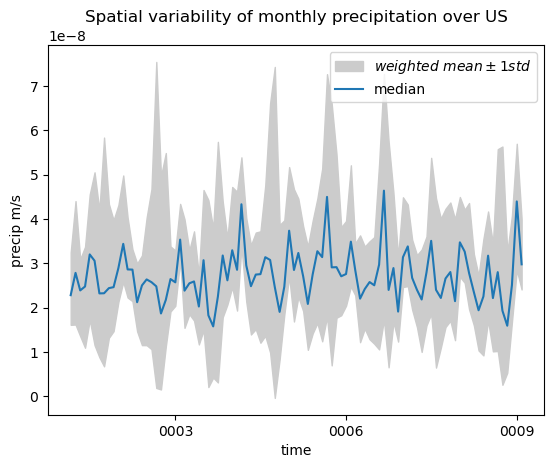

In [28]:
##### to be implemented...
# If you want to take weighted mean, you also need to apply weights to the standard deviation
US_precip = ds_new.cam_out_PRECT.sel(lat = slice(24, 50.5), lon = slice(240,290))
mean_plus_std = US_precip.weighted(weights).mean(dim=('lat','lon'))+US_precip.weighted(weights).std(dim=('lat','lon'))
mean_minus_std = US_precip.weighted(weights).mean(dim=('lat','lon'))-US_precip.weighted(weights).std(dim=('lat','lon'))

plt.fill_between(US_precip.time.values,
                 mean_plus_std.values,
                 mean_minus_std.values,
                 color='0.8', label = r'$weighted \ mean \pm 1 std$')

# For median values, do not need to take the weights
US_precip.median(dim=('lat','lon')).plot(label='median')
plt.title('Spatial variability of monthly precipitation over US')
plt.ylabel('precip m/s')
plt.legend()

### [Analysis 2] Histograms/distributions

Please use PRECT (the variable you created in Analysis 1) and ds_new. 

Convert the unit of precipitation from m/s to mm/hr or mm/day, and plot:

1. a histogram for monthly precipitation from all grids across the globe; 
2. a histogram for daily precipitation from all grids 

to show the statistical distributions of the variable values. Use log scale for y axis. You can plot them on the same graph or do it separately. 

See [xarray.plot.hist](https://docs.xarray.dev/en/stable/generated/xarray.plot.hist.html). 

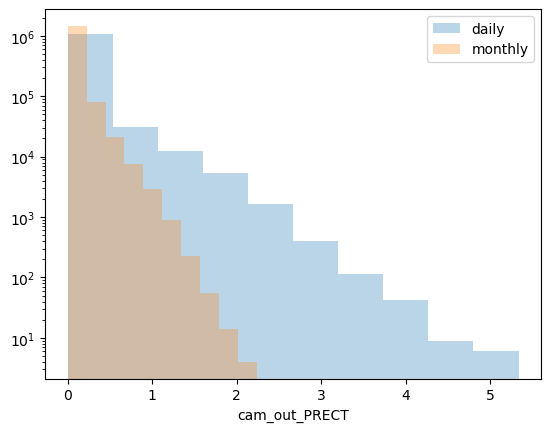

In [29]:
##### to be implemented...
# m/s = 1000mm/(1/3600hr)

PRECT = PRECT*3600*1000
ds_new['cam_out_PRECT'] = ds_new.cam_out_PRECT*3600*1000

PRECT.resample(time='1D').mean().plot.hist(yscale='log', label='daily', alpha=0.3)
ds_new.cam_out_PRECT.plot.hist(yscale='log', label='monthly', alpha=0.3)

plt.legend()

Simply describe what you see, especially the difference.

### [Analysis 3] Climatology, Anomalies and Normalization

#### 2D horizontal maps

**<span style="color:blue"> We'll use *ds_new* for the rest analysis from here unless specified.</span>**

Review the lecture on Day 2, read **[Climatology vs weather](https://drought.unl.edu/Education/DroughtIn-depth/WhatisClimatology.aspx)** and **[Current Climate](https://climateknowledgeportal.worldbank.org/country/united-states/climate-data-historical)** to understand what is climatology - naively it can be interpreted as the average for weather in an area over decades. In other words, climatology is what would a typical year / the average condition be like for climate variables, such as precipitation or temperature, in a region or over the globe. It can be the seasonal cycles or just annual mean condition, depending on your goal.

Choose a proper projection (use cartopy) and visualize the 2D maps of climatology status for total precipitation and surface net SW using subplot. Choose a nice colormap and annotate the information properly.

Hint: it can be achieved by simply taking temporal mean. **You are not yet required to deal with seasonal cycles (namely, don't group data by month)** in this analysis.

Text(0.5, 1.0, 'Climatology of Net SW at Surface (W/m2)')

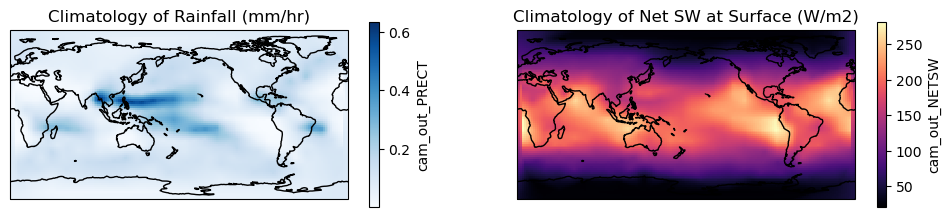

In [30]:
##### to be implemented...
import cartopy.crs as ccrs
import cartopy

fig, ax = plt.subplots(figsize = (12,4), ncols=2, 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},)

ax[0].set_global()
ax[0].coastlines()

ax[1].set_global()
ax[1].coastlines()

ds_new.cam_out_PRECT.mean('time').plot(ax = ax[0], cmap = 'Blues', transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.6})
ds_new.cam_out_NETSW.mean('time').plot(ax = ax[1], cmap = 'magma', transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.6})

ax[0].set_title('Climatology of Rainfall (mm/hr)')
ax[1].set_title('Climatology of Net SW at Surface (W/m2)')

#### Zonal mean climatology
Other than plotting the 2D maps, we can also plot curves of the zonal mean radiation/precipitation. 

Hint: Plot the curve along latitude, with x-axis as lat and y-axis as the zonnal mean variables. You can plot radiation and precipitation in two subplots or plot them together using **[twin axes](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html#sphx-glr-gallery-subplots-axes-and-figures-two-scales-py)**.


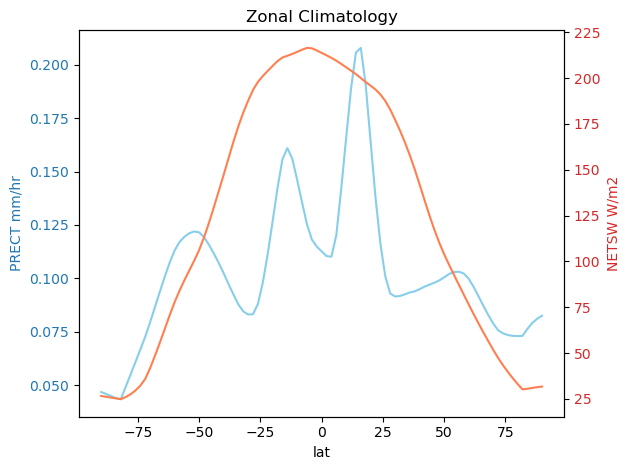

In [37]:
##### to be implemented...

fig, ax1 = plt.subplots()

color = 'tab:blue'
ds_new.cam_out_PRECT.mean('time').mean('lon').plot(ax = ax1, c = 'skyblue')
ax1.set_xlabel('lat')
ax1.set_ylabel('PRECT mm/hr', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ds_new.cam_out_NETSW.mean('time').mean('lon').plot(ax = ax2, c = 'coral')
ax2.set_ylabel('NETSW W/m2', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_title('Zonal Climatology')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Simply describe the patterns.

#### Anomalies and standard anomalies

What is anomaly in climate sciences? Read **[Temperature Anomalies](https://www.ncei.noaa.gov/access/monitoring/dyk/anomalies-vs-temperature)** to learn more. Anomalies can be visualized as time series plots or maps. 

When you want to compare the variability of two variables whose original magnitudes are different, it often helps to express the data in terms of **[Standardized Anomalies](https://iridl.ldeo.columbia.edu/dochelp/StatTutorial/Climatologies/index.html)**. 

Visualize the time series of standardized anomalies for *global mean* precipitation & radiation on the same plot. Take a rolling mean with time window as 3-month to make the curves smoother. Show the legend properly.

Text(0.5, 1.0, 'Standard anomalies')

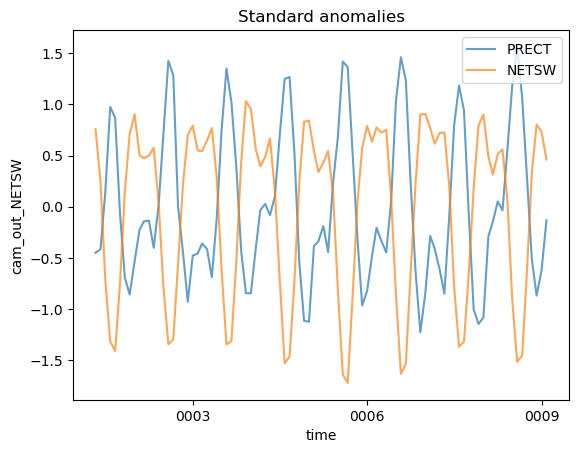

In [36]:
##### to be implemented...
ds_weighted = ds_new.weighted(weights).mean(dim=('lat','lon'))
stand_anom = (ds_weighted - ds_weighted.mean('time'))/ds_weighted.std('time')

stand_anom.cam_out_PRECT.rolling(time=3).mean().plot(label='PRECT', alpha=0.7)
stand_anom.cam_out_NETSW.rolling(time=3).mean().plot(label='NETSW', alpha=0.7)

plt.legend()
plt.title('Standard anomalies')

Did you find any pattern? Which variable has stronger variability?

### [Analysis 4] Seasonality

We've seen that the data exhibits strong seasonality/periods in the previous analysis. We can further visualize the seasonal cycles from the perspective of climatology, using *Groupby* function.

Groupby the *global mean* precipitation from ds_new in by month and take the mean values. Plot precipitation respect to month. 

Compare with plots in [paper for net SW surface](https://www.researchgate.net/figure/Climatological-mean-annual-cycle-of-a-net-shortwave-radiation-b-net-longwave-radiation_fig4_314121791) and [paper for precip](https://www.researchgate.net/figure/Mean-seasonal-cycle-of-a-temperatures-over-the-globe-the-tropical-ocean-and-the_fig1_234072312).

Hint: the x-axis should be Jan, Feb, … Dec; and y-axis should be the groupby mean of *global mean* precipitation for each month.



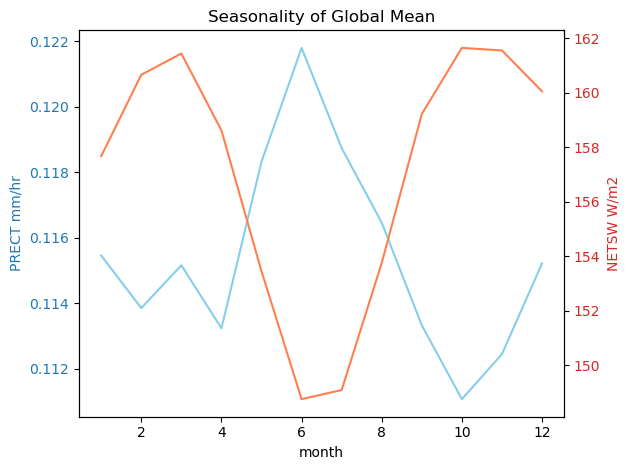

In [35]:
##### to be implemented...

fig, ax1 = plt.subplots()

color = 'tab:blue'
# ds_new.cam_out_PRECT.groupby('time.month').mean().weighted(weights).mean(dim=('lat','lon')).plot(ax = ax1, c = 'coral')
ds_weighted.cam_out_PRECT.groupby('time.month').mean().plot(ax = ax1, c = 'skyblue')
ax1.set_xlabel('month')
ax1.set_ylabel('PRECT mm/hr', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
# ds_new.cam_out_NETSW.groupby('time.month').mean().weighted(weights).mean(dim=('lat','lon')).plot(ax = ax2, c = 'skyblue')
ds_weighted.cam_out_NETSW.groupby('time.month').mean().plot(ax = ax2, c = 'coral')
ax2.set_ylabel('NETSW W/m2', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_title('Seasonality of Global Mean')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

We can also groupby the data by seasons, sush as JJA (Jun, Jul, Aug) or DJF (Dec, Jan, Feb).

Plot a map of radiation difference in summer and winter over the whole globe (e.g. JJA vs DJF).


Text(0.5, 1.0, 'Net SW (surface) difference in JJA and DJF')

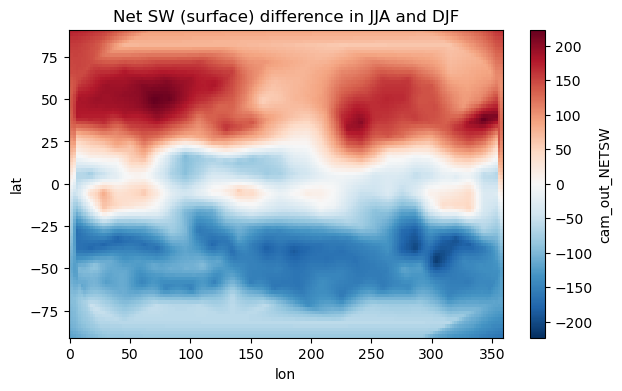

In [31]:
##### to be implemented...

season_data = ds_new.cam_out_NETSW.groupby('time.season').mean()
diff = season_data.sel(season='JJA') - season_data.sel(season='DJF')
diff.plot(figsize=(7,4))
plt.title('Net SW (surface) difference in JJA and DJF')

What did you find?

### [Analysis 5] Vertical profiles of the 3D variables

#### Interpolation of data

Danger: <span style="color:red">restart your server and select memory = 64G or 128G option for this analysis. Only do this when you process this task.</span>

Till now, we only visualize and process a few 2D variables, we can also create an interpolated dataset/dataarray for the 3D variable **state_t**, air temperature, with *lev* dimension following the data processing steps to generate ds_new. 

In order to avoid requesting huge memory, we'll only keep the 3D data at every 4th (try 6th when the current memory size is still not sufficient) lev coordinate points and resample it to be monthly data.

In [32]:
##### to be implemented...

lev = ds_origin.lev
lev = lev[0::4]
ds_3d = ds_origin.sel(lev=lev)

# try to release some memory by deleting useless datasets if needed
# del ds_origin, ds, ds_grid 

# memory failure: ds_3d.resample(time='1M').mean(dim='time')
ds_3d = ds_3d.state_t.resample(time='1M').mean(dim='time')
ds_3d

<xarray.DataArray 'state_t' (time: 96, lev: 15, ncol: 384)>
array([[[214.60079058, 214.27210401, 215.95399968, ..., 220.33747725,
         219.08667956, 222.69017314],
        [256.474451  , 257.18148995, 255.4508557 , ..., 257.04865408,
         255.46186809, 257.2889515 ],
        [242.67713399, 243.60478954, 239.709908  , ..., 239.60113079,
         238.86305058, 236.84432468],
        ...,
        [285.61791012, 282.63949734, 287.68665882, ..., 258.30273665,
         258.16479273, 266.1222675 ],
        [289.33287347, 286.20997223, 291.66624981, ..., 261.85120178,
         262.20523927, 269.56758682],
        [292.91201455, 289.51750077, 295.92761673, ..., 264.79631987,
         265.86228184, 272.75077368]],

       [[216.40196721, 216.43291174, 219.04591955, ..., 223.3106913 ,
         227.5432702 , 225.99068078],
        [253.25952652, 253.64196931, 253.93929804, ..., 254.10925172,
         253.12614011, 255.14400514],
        [242.50879283, 242.59560859, 241.2840745 , ..., 237.49335834,
         232.46228641, 234.33736778],
...
        [283.69485512, 280.57898592, 287.34896978, ..., 256.94479914,
         260.02574825, 265.12796404],
        [286.92782787, 283.87590729, 290.58449911, ..., 259.86465785,
         264.17933736, 268.9592294 ],
        [290.202198  , 287.11554219, 293.84373983, ..., 262.78196378,
         267.92386204, 272.51192031]],

       [[214.61740449, 214.74216229, 216.45498244, ..., 217.94139045,
         217.66129648, 219.99993656],
        [256.57869471, 257.76161548, 254.31809491, ..., 253.10449549,
         249.75072509, 251.42069071],
        [242.75418351, 244.09963869, 239.36125428, ..., 233.41465194,
         230.94350929, 231.55877065],
        ...,
        [284.41070015, 281.68384048, 287.83852709, ..., 251.33124285,
         254.22582144, 257.9184995 ],
        [287.72685955, 284.76834612, 291.10671059, ..., 253.27499893,
         258.69711672, 262.18916107],
        [291.17664157, 288.16784965, 294.57465119, ..., 255.62637161,
         262.55382548, 266.11648017]]])
Coordinates:
  * time     (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
Dimensions without coordinates: lev, ncol

In [34]:
##### to be implemented...
# create a nan-value xr dataset to contain new remapped & interpolated data 
data_var = np.empty([len(time), len(lev), len(nlat), len(nlon)])
data_var[:,:,:,:] = np.nan

ds_new3d = xr.Dataset(
     data_vars={
         v: (("time","lev","lat","lon"), data_var)
         for v in ['state_t']
     },
     coords={
         "time": ds_3d.time,
         "lev": ds_3d.lev,
         "lat": nlat,
         "lon": nlon,
    },
)

state_t = data_var.copy()

# interpolate the data using pyngl
# optional: use multiprocessing to save the running time

for it, tt in tqdm(enumerate(ds_3d.time)):
    for il, ll in enumerate(ds_3d.lev):
        data = ds_3d.sel(time=tt,lev=ll).values
        iarr = Ngl.natgrid(lat, lon, data, nlat, nlon) #.squeeze()
        state_t[it,il,:] = iarr
        
ds_new3d['state_t'].values = state_t

ds_new3d

<xarray.Dataset>
Dimensions:  (time: 96, lev: 15, lat: 91, lon: 180)
Coordinates:
  * time     (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * lev      (lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) int64 0 2 4 6 8 10 12 14 ... 344 346 348 350 352 354 356 358
Data variables:
    state_t  (time, lev, lat, lon) float64 217.0 217.0 217.1 ... 267.5 267.6

#### Vertical structure of state_t from any grid 

Select any one grid (or domain) as you want and take the temporal mean (you also need to take the horizontal mean if you select a domain instead one grid before plotting). 

Plot the state_t values along the altitude/height level. Your x-axsis should be the values of state_t, and the y-axis should be lev. 

Compare your plots with [this website](https://crisp.nus.edu.sg/~research/tutorial/atmos.htm#:~:text=The%20vertical%20profile%20of%20the,%2C%20mesopause%20and%20thermopause%2C%20respectively.).

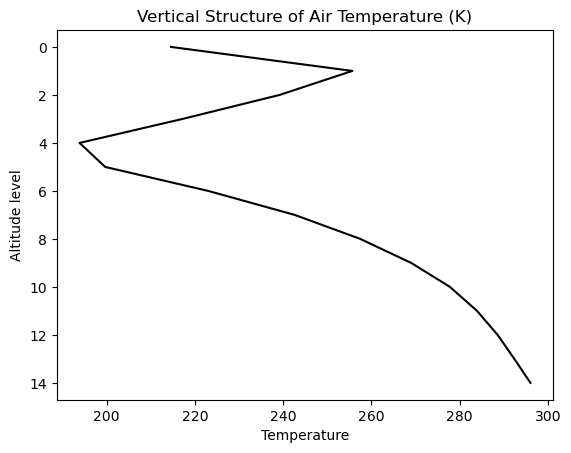

In [35]:
##### to be implemented...
fig, ax = plt.subplots()
t_tropic_mean = ds_new3d.state_t.sel(lat=slice(-20,20)).weighted(weights).mean(dim=('lat','lon','time'))

ax.plot(t_tropic_mean.values, t_tropic_mean.lev.values, color='k')
ax.set_xlabel('Temperature')
ax.set_ylabel('Altitude level')
ax.set_title('Vertical Structure of Air Temperature (K)')
plt.gca().invert_yaxis()

Which level (lev=0 or lev=9), do you think, is closer to the earth surface?

#### Seasonality or distribution across the latitudes

The vertical profiles of state_t from a domain/grid can show seasonal variation and can also exhibit geographic characteristics respect to the latitude. 

Make ONE plot to show Either the seasonal change or geographic characteristics of the air temperature.

Hint: one way to visualize the seasonal change is to take the JJA and DJF mean of domain mean state_t, and plot these two vertical curves on the same figure (for the figure, x-axis: stat_t, y_axis: lev). 

Hint: one way to visualize the geographic difference is to take the temporal and zonal mean of the state_t, so for each lat and lev, you have one state_t value (for the figure, x-axis: lat, y_axis: lev, color: state_t). 

You do not need to make the figure exactly following these steps. Please unleash your creativity and it will be fine as long as you plot something that makes sense and helps understand the concepts.



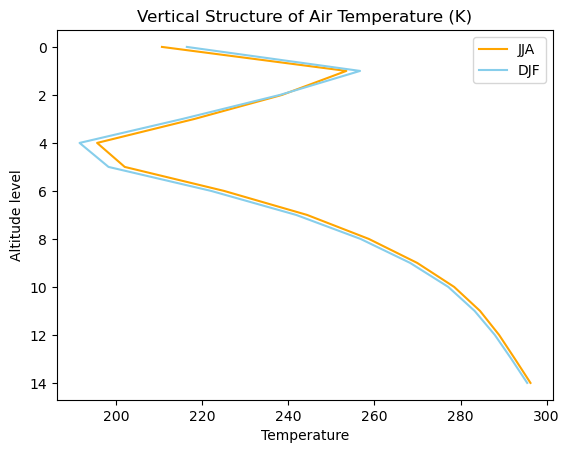

In [36]:
##### to be implemented...
fig, ax = plt.subplots()
t_tropic_season = ds_new3d.state_t.sel(lat=slice(-20,20)).weighted(weights).mean(dim=('lat','lon')).groupby('time.season').mean()

ax.plot(t_tropic_season.sel(season='JJA').values, t_tropic_season.sel(season='JJA').lev.values, color='orange', label='JJA')
ax.plot(t_tropic_season.sel(season='DJF').values, t_tropic_season.sel(season='DJF').lev.values, color='skyblue', label='DJF')

ax.legend()
ax.set_xlabel('Temperature')
ax.set_ylabel('Altitude level')
ax.set_title('Vertical Structure of Air Temperature (K)')
plt.gca().invert_yaxis()

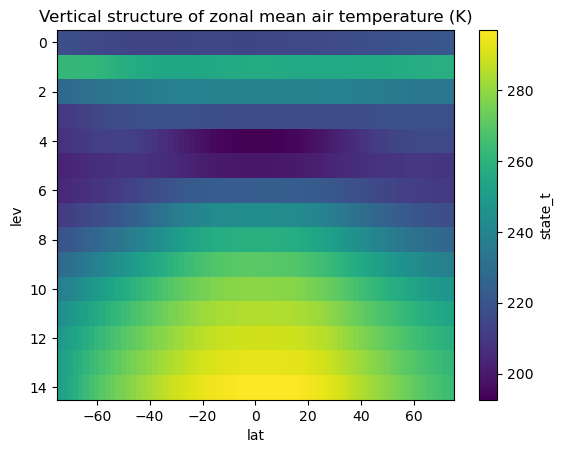

In [48]:
##### to be implemented...
fig, ax = plt.subplots()
t_tropic_season = ds_new3d.state_t.sel(lat=slice(-75,75)).mean(dim=('lon','time'))
t_tropic_season.plot(ax=ax)

ax.set_xlabel('lat')
ax.set_ylabel('lev')
ax.set_title('Vertical structure of zonal mean air temperature (K)')
plt.gca().invert_yaxis()

### [Analysis 6] Simple Machine Learning
#### Linear regression

Change the (weighted or unweighted) *global mean* data from xarray.dataset to numpy.array format and fit a linear regression between precip and radiation (just use the monthly data from ds_new). Namely, fit y = precipitation as a function of x = radiation using linear regression. There are many [Python packages](https://towardsdatascience.com/five-regression-python-modules-that-every-data-scientist-must-know-a4e03a886853) that you can use.

Visualize your predicted data along with the raw data. Understand the meaning of the returned values, when using existing functions.

You are not asked to tune the regression model for accuracy. 


slope: -0.000564947629135676


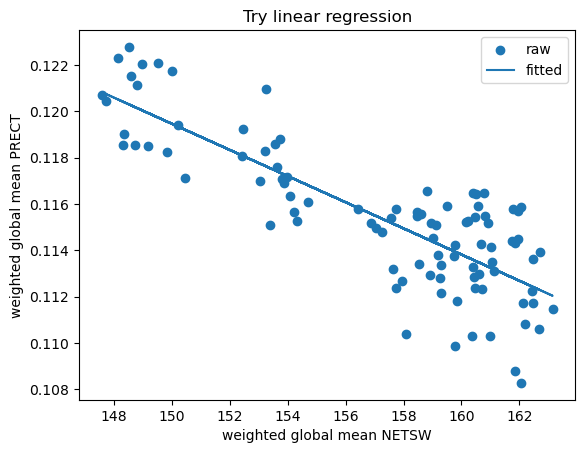

correlation -0.8227073181706551 p-value 8.68971580349205e-25


In [45]:
##### to be implemented...
from scipy import stats

x = ds_weighted.cam_out_NETSW.values
y = ds_weighted.cam_out_PRECT.values

slope, intercept, r, p, std_err = stats.linregress(x, y)
print('slope:',slope)

def myfunc(x):
    return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y, label='raw')
plt.plot(x, mymodel, label='fitted')
plt.legend()
plt.xlabel('weighted global mean NETSW')
plt.ylabel('weighted global mean PRECT')
plt.title('Try linear regression')
plt.show()
print('correlation', r, 'p-value', p)

Replace the precip and radiation data with their standard anomalies. Is there any difference?

slope: -0.8227073181706556


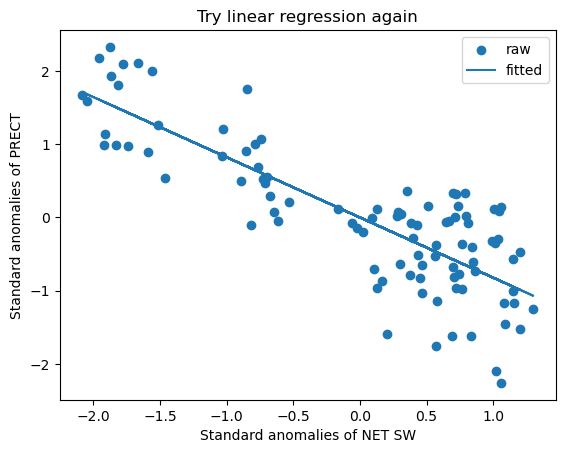

correlation -0.8227073181706552 p-value 8.689715803491866e-25


In [44]:
##### to be implemented...
x = stand_anom.cam_out_NETSW.values
y = stand_anom.cam_out_PRECT.values

slope, intercept, r, p, std_err = stats.linregress(x, y)
print('slope:',slope)

mymodel = list(map(myfunc, x))

plt.scatter(x, y, label='raw')
plt.plot(x, mymodel, label='fitted')
plt.legend()
plt.xlabel('Standard anomalies of NET SW')
plt.ylabel('Standard anomalies of PRECT')
plt.title('Try linear regression again')
plt.show()
print('correlation', r, 'p-value', p)

Are you satisfied with your model and prediction? How to understand the relationship (think of physical mechanisms)?